In [ ]:
import pandas as pd

df = pd.read_csv('/content/Amazon-Products.csv')
display(df.head())

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990"
1,1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990"
2,2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990"
3,3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990"
4,4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790"


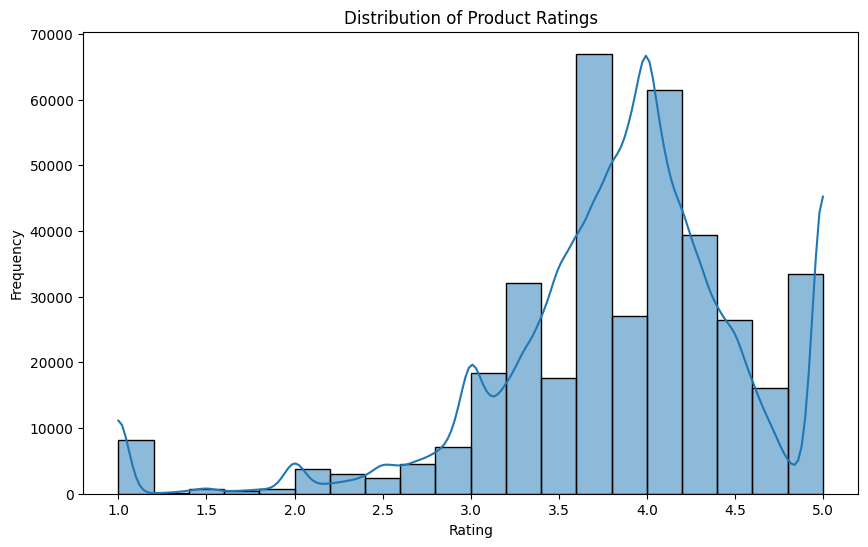

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'ratings' to numeric, coercing errors
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

# Drop rows with NaN ratings for plotting
ratings_df = df.dropna(subset=['ratings'])

plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['ratings'], bins=20, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
!pip install pyspark

In [ ]:
import os
java_home = os.environ.get('JAVA_HOME')
print(java_home)

None


In [ ]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("AmazonSentimentAnalysis") \
    .getOrCreate()

print("SparkSession created successfully!")

SparkSession created successfully!


In [ ]:
# Load the dataset into a Spark DataFrame
spark_df = spark.read.csv('/content/Amazon-Products.csv', header=True, inferSchema=True)

# Display the schema and the first few rows of the Spark DataFrame
spark_df.printSchema()
spark_df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- image: string (nullable = true)
 |-- link: string (nullable = true)
 |-- ratings: string (nullable = true)
 |-- no_of_ratings: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- actual_price: string (nullable = true)

+---+--------------------+-------------+----------------+--------------------+--------------------+-------+-------------+--------------+------------+
|_c0|                name|main_category|    sub_category|               image|                link|ratings|no_of_ratings|discount_price|actual_price|
+---+--------------------+-------------+----------------+--------------------+--------------------+-------+-------------+--------------+------------+
|  0|Lloyd 1.5 Ton 3 S...|   appliances|Air Conditioners|https://m.media-a...|https://www.amazo...|    4.2|        2,255|       ₹32,999|

In [ ]:
from pyspark.sql.functions import col, count

# Check for null values in the 'name' column
print("Count of null values in 'name' column before dropping:")
spark_df.select(count(col("name")).alias("non_null_count")).show()
spark_df.filter(col("name").isNull()).count()

# Drop rows where 'name' is null, as it's essential for sentiment analysis
processed_spark_df = spark_df.dropna(subset=['name'])

# Verify null values in the 'name' column after dropping
print("Count of null values in 'name' column after dropping:")
processed_spark_df.select(count(col("name")).alias("non_null_count")).show()
processed_spark_df.filter(col("name").isNull()).count()

# Select the 'name' column for further text processing
text_data = processed_spark_df.select("name")

text_data.show(5)

Count of null values in 'name' column before dropping:
+--------------+
|non_null_count|
+--------------+
|        551585|
+--------------+

Count of null values in 'name' column after dropping:
+--------------+
|non_null_count|
+--------------+
|        551585|
+--------------+

+--------------------+
|                name|
+--------------------+
|Lloyd 1.5 Ton 3 S...|
|LG 1.5 Ton 5 Star...|
|LG 1 Ton 4 Star A...|
|LG 1.5 Ton 3 Star...|
|Carrier 1.5 Ton 3...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Tokenize the 'name' column
tokenizer = Tokenizer(inputCol="name", outputCol="words")
words_df = tokenizer.transform(text_data)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_words_df = remover.transform(words_df)

# Display the results
filtered_words_df.show(5)

+--------------------+--------------------+--------------------+
|                name|               words|      filtered_words|
+--------------------+--------------------+--------------------+
|Lloyd 1.5 Ton 3 S...|[lloyd, 1.5, ton,...|[lloyd, 1.5, ton,...|
|LG 1.5 Ton 5 Star...|[lg, 1.5, ton, 5,...|[lg, 1.5, ton, 5,...|
|LG 1 Ton 4 Star A...|[lg, 1, ton, 4, s...|[lg, 1, ton, 4, s...|
|LG 1.5 Ton 3 Star...|[lg, 1.5, ton, 3,...|[lg, 1.5, ton, 3,...|
|Carrier 1.5 Ton 3...|[carrier, 1.5, to...|[carrier, 1.5, to...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

# Define lists of positive and negative keywords (you can expand these lists)
positive_keywords = ["great", "excellent", "amazing", "best", "love", " अधिकारिक ", " असली ", " अच्छा ", " बढ़िया "]
negative_keywords = ["bad", "poor", "terrible", "worst", "disappointing", " खराब ", " बुरा "]

# Create a UDF to determine sentiment based on keywords
def simple_sentiment_udf(words):
    if words is None:
        return 0
    sentiment = 0
    for word in words:
        if word.lower() in positive_keywords:
            sentiment += 1
        elif word.lower() in negative_keywords:
            sentiment -= 1
    return sentiment

# Register the UDF
sentiment_analyzer = udf(simple_sentiment_udf, IntegerType())

# Apply the sentiment analysis UDF to the DataFrame
sentiment_df = filtered_words_df.withColumn("sentiment_score", sentiment_analyzer(col("filtered_words")))

# Display the results with sentiment scores
sentiment_df.select("name", "filtered_words", "sentiment_score").show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|name                                                                                                                         |filtered_words                                                                                                                                  |sentiment_score|
+-----------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...|[lloyd

In [ ]:
# Analyze the distribution of sentiment scores
print("Sentiment Score Distribution:")
sentiment_df.groupBy("sentiment_score").count().orderBy("sentiment_score").show()

# Calculate summary statistics for sentiment scores
print("Sentiment Score Summary Statistics:")
sentiment_df.select("sentiment_score").describe().show()

Sentiment Score Distribution:
+---------------+------+
|sentiment_score| count|
+---------------+------+
|             -3|     1|
|             -2|     1|
|             -1|    52|
|              0|547466|
|              1|  3947|
|              2|   111|
|              3|     7|
+---------------+------+

Sentiment Score Summary Statistics:
+-------+--------------------+
|summary|     sentiment_score|
+-------+--------------------+
|  count|              551585|
|   mean|0.007492952128864998|
| stddev| 0.09020323735762827|
|    min|                  -3|
|    max|                   3|
+-------+--------------------+



/tmp/ipython-input-3126622700.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment_score', y='count', data=sentiment_counts_pd, palette='viridis')


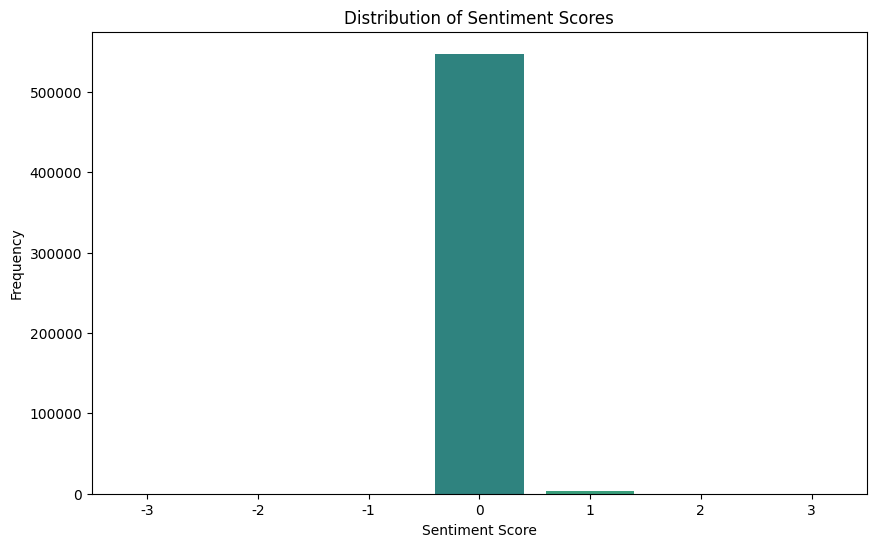

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect the sentiment score counts from Spark to pandas
sentiment_counts_pd = sentiment_df.groupBy("sentiment_score").count().orderBy("sentiment_score").toPandas()

# Create a bar plot of the sentiment score distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment_score', y='count', data=sentiment_counts_pd, palette='viridis')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from pyspark.sql.functions import col, count

# Check for null values in 'main_category' and 'sub_category' columns
print("Count of null values in 'main_category' column before dropping:")
spark_df.filter(col("main_category").isNull()).count()

print("Count of null values in 'sub_category' column before dropping:")
spark_df.filter(col("sub_category").isNull()).count()

Count of null values in 'main_category' column before dropping:
Count of null values in 'sub_category' column before dropping:


3

**Reasoning**:
Drop rows with null values in 'main_category' or 'sub_category' and verify the removal.



In [ ]:
# Drop rows where 'main_category' or 'sub_category' is null
categorization_df = spark_df.dropna(subset=['main_category', 'sub_category'])

# Verify null values in the 'main_category' and 'sub_category' columns after dropping
print("Count of null values in 'main_category' column after dropping:")
categorization_df.filter(col("main_category").isNull()).count()

print("Count of null values in 'sub_category' column after dropping:")
categorization_df.filter(col("sub_category").isNull()).count()

Count of null values in 'main_category' column after dropping:
Count of null values in 'sub_category' column after dropping:


0

**Reasoning**:
Select the 'name' column as the feature and 'main_category' as the label for the categorization task.



In [ ]:
# Select the feature and label columns
feature_column = "name"
label_column = "main_category"

# Select the relevant columns for categorization
categorization_data = categorization_df.select(col(feature_column), col(label_column))

# Display the first few rows of the selected data
categorization_data.show(5)

+--------------------+-------------+
|                name|main_category|
+--------------------+-------------+
|Lloyd 1.5 Ton 3 S...|   appliances|
|LG 1.5 Ton 5 Star...|   appliances|
|LG 1 Ton 4 Star A...|   appliances|
|LG 1.5 Ton 3 Star...|   appliances|
|Carrier 1.5 Ton 3...|   appliances|
+--------------------+-------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Tokenize the 'name' column
tokenizer = Tokenizer(inputCol="name", outputCol="words")
words_df = tokenizer.transform(categorization_data)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_words_df = remover.transform(words_df)

# Initialize and apply HashingTF
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
tf_df = hashing_tf.transform(filtered_words_df)

# Initialize, fit and apply IDF
idf = IDF(inputCol="raw_features", outputCol="features")
tfidf_model = idf.fit(tf_df)
tfidf_df = tfidf_model.transform(tf_df)

# Display the schema and the first few rows of the resulting DataFrame
tfidf_df.printSchema()
tfidf_df.select("name", "filtered_words", "raw_features", "features").show(5, truncate=False)

root
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

+-----------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Index the label column 'main_category'
indexer = StringIndexer(inputCol="main_category", outputCol="label")
indexed_df = indexer.fit(tfidf_df).transform(tfidf_df)

# Assemble the features into a single vector
assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")
assembled_df = assembler.transform(indexed_df)

# Sample a smaller subset of the data to avoid memory errors
# Adjust the fraction (e.g., 0.1 for 10%) as needed
sampled_df = assembled_df.sample(False, 0.1, seed=42)

# Split the sampled data into training and testing sets
(training_data, testing_data) = sampled_df.randomSplit([0.8, 0.2], seed=42)

# Cache the training and testing data
training_data.cache()
testing_data.cache()

# Display schema and show first rows
training_data.printSchema()
print("Training Data:")
training_data.show(5)
print("Testing Data:")
testing_data.show(5)

root
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- features_vector: vector (nullable = true)

Training Data:
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|                name|       main_category|               words|      filtered_words|        raw_features|            features|label|     features_vector|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|"""PH"" POSHAKHUB...|        Ankle Length|["""ph"", poshakh...|["""ph"", poshakh...|(1

In [ ]:
from pyspark.ml.classification import NaiveBayes

# Initialize the MultinomialNB model
nb = NaiveBayes(labelCol="label", featuresCol="features_vector")

print("Multinomial Naive Bayes model initialized.")

Multinomial Naive Bayes model initialized.


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train the Naive Bayes model
model = nb.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy on the test data: {accuracy}")

# You can also evaluate other metrics like F1-score, precision, and recall
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score on the test data: {f1_score}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Weighted Precision on the test data: {precision}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Weighted Recall on the test data: {recall}")

Accuracy on the test data: 0.7861351500644449
F1 Score on the test data: 0.7998582300457255
Weighted Precision on the test data: 0.8208010114706171
Weighted Recall on the test data: 0.7861351500644448


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train the Naive Bayes model
model = nb.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy on the test data: {accuracy}")

# You can also evaluate other metrics like F1-score, precision, and recall
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score on the test data: {f1_score}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Weighted Precision on the test data: {precision}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Weighted Recall on the test data: {recall}")

Accuracy on the test data: 0.7861351500644449
F1 Score on the test data: 0.7998582300457255
Weighted Precision on the test data: 0.8208010114706171
Weighted Recall on the test data: 0.7861351500644448


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.5, 1.0]) \
    .build()

# Create an Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Create CrossValidator
cv = CrossValidator(estimator=nb,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3) # Use 3+ folds in practice

print("CrossValidator set up with parameter grid and evaluator.")

CrossValidator set up with parameter grid and evaluator.


In [ ]:
# Run cross-validation, and choose the best set of parameters.
cv_model = cv.fit(training_data)

print("Cross-validation completed and the best model is selected.")

Cross-validation completed and the best model is selected.


In [ ]:
# Get the best model from the CrossValidatorModel
best_model = cv_model.bestModel

print("Best model from cross-validation accessed.")

Best model from cross-validation accessed.


In [ ]:
# Use the best model to make predictions on the testing data
predictions = best_model.transform(testing_data)

# Display the first few rows of the predictions DataFrame
predictions.select("name", "main_category", "prediction").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------+----------+
|name                                                                                                                             |main_category                                     |prediction|
+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------+----------+
|"""TGC"" Wine Colour Plain Matt Metal Bangle / Win Color Chudi Set for Women and Girl (Pack of 24 Bangles)"                      |accessories                                       |0.0       |
|"3M Scotch Titanium Scissors | 8"" Multipurpose | Easy-Clean                                                                     | Non-Stick Blades | Ergonomic Handles | for Fabric|0.0       |
|"8 Feet Long Tripod Stand (84

In [ ]:
# Run cross-validation, and choose the best set of parameters.
cv_model = cv.fit(training_data)

print("Cross-validation completed and the best model is selected.")

Cross-validation completed and the best model is selected.


In [ ]:
# Get the best model from the CrossValidatorModel
best_model = cv_model.bestModel

print("Best model from cross-validation accessed.")

Best model from cross-validation accessed.


In [ ]:
# Use the best model to make predictions on the testing data
predictions = best_model.transform(testing_data)

# Display the first few rows of the predictions DataFrame
predictions.select("name", "main_category", "prediction").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------+----------+
|name                                                                                                                             |main_category                                     |prediction|
+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------+----------+
|"""TGC"" Wine Colour Plain Matt Metal Bangle / Win Color Chudi Set for Women and Girl (Pack of 24 Bangles)"                      |accessories                                       |0.0       |
|"3M Scotch Titanium Scissors | 8"" Multipurpose | Easy-Clean                                                                     | Non-Stick Blades | Ergonomic Handles | for Fabric|0.0       |
|"8 Feet Long Tripod Stand (84

In [ ]:
from pyspark.ml.feature import IndexToString

# Create IndexToString transformer to map the prediction index back to the original label
# We need to fit it on the DataFrame that has both the indexed label and the original string label
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=indexer.fit(tfidf_df).labels)

# Transform the predictions DataFrame to add the original predicted labels
predictions_with_labels = labelConverter.transform(predictions)

# Display the results with original and predicted labels
predictions_with_labels.select("name", "main_category", "predictedLabel", "prediction").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------+-------------------+----------+
|name                                                                                                                             |main_category                                     |predictedLabel     |prediction|
+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------+-------------------+----------+
|"""TGC"" Wine Colour Plain Matt Metal Bangle / Win Color Chudi Set for Women and Girl (Pack of 24 Bangles)"                      |accessories                                       |accessories        |0.0       |
|"3M Scotch Titanium Scissors | 8"" Multipurpose | Easy-Clean                                                                     | Non-Stick Bl

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Evaluate the model on the test data with detailed metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Calculate and print weighted and overall metrics
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"Overall Accuracy: {accuracy}")
print(f"Overall F1 Score: {f1_score}")
print(f"Overall Weighted Precision: {weighted_precision}")
print(f"Overall Weighted Recall: {weighted_recall}")

# To get per-class metrics, we can generate a confusion matrix and calculate manually
# This requires collecting a potentially large amount of data to the driver

# Convert predictions to RDD of (prediction, label) pairs
predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Print confusion matrix
print("Confusion Matrix:")
print(metrics.confusionMatrix().toArray())

# Print metrics by label
print("Metrics by label:")
# Get the unique labels present in the predictionAndLabels RDD
unique_labels_in_rdd = predictionAndLabels.map(lambda x: x[1]).distinct().collect()

# Get the original string labels from the indexer
original_labels = indexer.fit(tfidf_df).labels

for label in unique_labels_in_rdd:
    # Ensure the label is within the bounds of original_labels list
    if int(label) < len(original_labels):
        print(f"--- Class {int(label)} ({original_labels[int(label)]}) ---")
        precision = metrics.precision(label)
        recall = metrics.recall(label)
        print(f"Precision = {precision}")
        print(f"Recall = {recall}")
        # Calculate F1 score manually
        if (precision + recall) == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        print(f"F1 Score = {f1}")
    else:
        print(f"--- Class {int(label)} (Label index out of bounds) ---")

Overall Accuracy: 0.7861351500644449
Overall F1 Score: 0.7998582300457255
Overall Weighted Precision: 0.8208010114706171
Overall Weighted Recall: 0.7861351500644448


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[1.798e+03 2.000e+00 8.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.403e+03 2.600e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [7.000e+00 8.800e+01 1.311e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [1.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
Metrics by label:
--- Class 0 (accessories) ---
Precision = 0.9117647058823529
Recall = 0.7746660922016372
F1 Score = 0.8376426741206615
--- Class 584 ( Non-Stick Blades | Ergonomic Handles | for Fabric) ---
Precision = 0.0
Recall = 0.0
F1 Score = 0.0
--- Class 598 ( Parking...") ---
Precision = 0.0
Recall = 0.0
F1 Score = 0.0
--- Class 680 ( Spacious Compartmen...") ---
Precision = 0.0
Recall = 0.0
F1 Score = 0.0
--- Class 12 (car & motorbike) ---
Precision = 0.6046511627906976
Recall = 0.7536231884057971
F1 Score = 0.6709677419354838
--- Class 6 (appliances) ---
Pre